In [123]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import json
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.optim import Adam
from torch.nn.functional import softmax
from torch import multinomial, tensor
import numpy as np
# GPU configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [124]:
class LyricsDataset(Dataset):
    def __init__(self, text, seq_length=50):
        self.chars = sorted(set(text) | {'<unk>'})  # Ensure '<unk>' is part of the character set
        self.char_to_int = {ch: i for i, ch in enumerate(self.chars)}
        self.int_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.data = [self.char_to_int.get(ch, self.char_to_int['<unk>']) for ch in text]  # Use '<unk>' for unknown chars
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.data[index:index+self.seq_length], dtype=torch.long),
            torch.tensor(self.data[index+1:index+self.seq_length+1], dtype=torch.long)
        )

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    def forward(self, x, states):
        x = self.embedding(x)
        lstm_out, states = self.lstm(x, states)
        return self.fc(lstm_out), states

    def init_states(self, batch_size):
        return (
            torch.tensor([]).new_zeros(self.num_layers, batch_size, self.hidden_dim, device=device),
            torch.tensor([]).new_zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        )

In [125]:
def load__data(filepath):
    df = pd.read_parquet(filepath)
    return df['Lyrics_clean'].str.cat(sep=' ')

In [126]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses1, accuracies1 = [], []
    model.train()
    for epoch in range(epochs):
        total_loss, total_accuracy = 0, 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            states = model.init_states(inputs.size(0))
            outputs, states = model(inputs, states)
            outputs = outputs.transpose(1, 2)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predictions from logits
            targets_flat = targets.view(-1)  # Flatten targets to align with predictions
            predicted_flat = predicted.view(-1)  # Flatten predictions to align with targets

            total_accuracy += (predicted_flat == targets_flat).float().mean().item()

        losses1.append(total_loss / len(dataloader))
        accuracies1.append(total_accuracy / len(dataloader))
        print(f'Epoch {epoch+1}, Loss: {losses1[-1]:.4f}, Accuracy: {accuracies1[-1]:.4f}')
    
    return losses1, accuracies1
        

In [127]:
def generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity=0.8):
    model.eval()
    input_indices = [char_to_int.get(char, char_to_int['<unk>']) for char in start_str.lower()]  # Safely handle unknown chars
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    text = start_str
    states = model.init_states(1)

    for _ in range(total_length):
        output, states = model(input_tensor, states)
        output_div = output / diversity
        probabilities = softmax(output_div[:, -1, :], dim=1)
        char_id = multinomial(probabilities, 1).item()
        char = int_to_char[char_id]
        text += char
        input_tensor = torch.tensor([[char_id]], dtype=torch.long).to(device)

    return text


In [128]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length, diversities):
    lyrics_with_names = {}
    for diversity in diversities:
        extended_lyrics = generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity)
        words = extended_lyrics.split()
        names = ["Harry", "Louis", "Zayn", "Niall", "Liam"]
        part_length = len(words) // len(names)
        parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
        leftover = len(words) % len(names)
        if leftover:
            parts[-1].extend(words[-part_length - leftover:])
        formatted_text = ""
        for name, part in zip(names, parts):
            formatted_text += f"{name}:\n{' '.join(part)}\n\n"
        lyrics_with_names[diversity] = formatted_text

    return lyrics_with_names




In [129]:
import matplotlib.pyplot as plt
# Function to plot losses and accuracies
def plot_metrics(losses, accuracies, title="Training Metrics"):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo-', label='Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'ro-', label='Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 1, Loss: 0.7189, Accuracy: 0.7809
Epoch 2, Loss: 0.2579, Accuracy: 0.9170
Epoch 3, Loss: 0.2348, Accuracy: 0.9223
Epoch 4, Loss: 0.2255, Accuracy: 0.9244
Epoch 5, Loss: 0.2196, Accuracy: 0.9258
Epoch 6, Loss: 0.2158, Accuracy: 0.9266
Epoch 7, Loss: 0.2126, Accuracy: 0.9275
Epoch 8, Loss: 0.2102, Accuracy: 0.9279
Epoch 9, Loss: 0.2083, Accuracy: 0.9283
Epoch 10, Loss: 0.2070, Accuracy: 0.9285


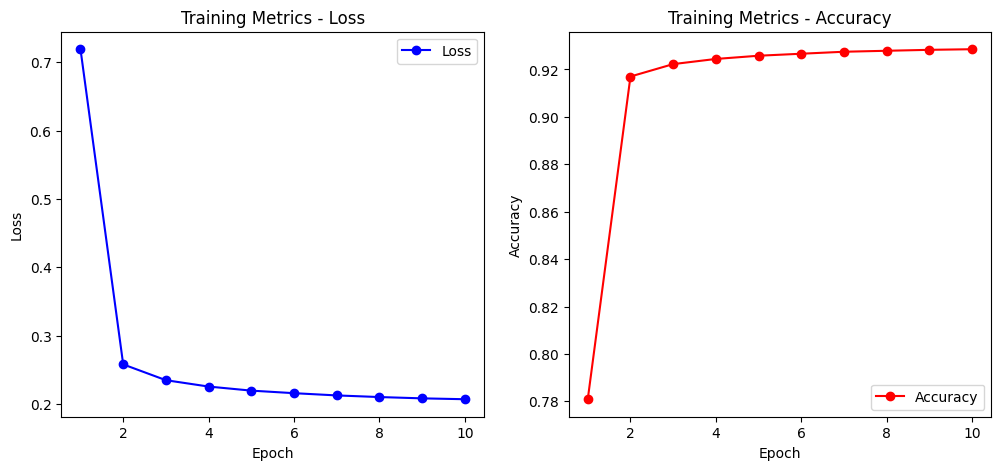

Model saved successfully.


In [130]:

    
lyrics_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
model_save_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\lstm_model_lyrics_generation.pth"

text_i = load__data(lyrics_path)
dataset = LyricsDataset(text_i)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = LSTMModel(len(dataset.char_to_int) + 1).to(device)
losses1, accuracies1 = train_model(model, dataloader, epochs=10, lr=0.001)


plot_metrics(losses1, accuracies1)
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully.")

    

In [131]:
def save_lyrics(div, lyrics, filename="generated_lyrics.txt"):
    with open(filename, 'w') as file:
        file.write(lyrics)


In [146]:
user_input = input("Enter the starting words of the song: ")
diversities = [0.04, 0.1, 0.2, 0.5, 1.0, 1.2, 1.5]
final_lyrics = generate_and_distribute_lyrics(model, user_input, dataset.int_to_char, dataset.char_to_int, 500, diversities)

for div, lyrics in final_lyrics.items():
        save_lyrics(div, lyrics)
        print(f"Diversity {div}:\n{lyrics}\n")
        

Diversity 0.04:
Harry:
saw you in blue dress who you doin' it for little black dress i can't take any more it's not right

Louis:
it's not right it's not right it's not right it's not right you know little black dress did you come here

Zayn:
alone it's too late it's too late it's too late it's too late to go home it's alright it's alright it's

Niall:
alright 'cause i'll take you home i wanna see the way you move for me ow little black dress who you

Liam:
doin' it for little black dress i can't take any more it's not right it's not right it's not right it's doin' it for little black dress i can't take any more it's not right it's not right it's not right it's not righ



Diversity 0.1:
Harry:
saw you in blue dress who you doin' it for little black dress i can't take any more it's not right it's

Louis:
not right it's not right it's not right it's not right you know little black dress did you come here alone it's

Zayn:
too late it's too late it's too late it's too late to go home it'

### with Oxford 3000


In [133]:
import matplotlib.pyplot as plt

def load_oxford_words(filepath):
    with open(filepath, 'r') as file:
        words = file.read().split()
    return ' '.join(words)  # Returning as a single string for easy combination

def load_combined_data(lyrics_path, oxford_path):
    lyrics = load__data(lyrics_path)
    oxford_words = load_oxford_words(oxford_path)
    combined_text = lyrics + ' ' + oxford_words
    return combined_text



In [150]:
def train_model2(model, dataloader, epochs=15, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses, accuracies = [], []
    
    model.train()
    for epoch in range(epochs):
        total_loss, total_accuracy = 0, 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            states = model.init_states(inputs.size(0))
            outputs, states = model(inputs, states)
            outputs = outputs.transpose(1, 2)  # Align outputs for loss calculation

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Accuracy calculation adjustments
            _, predicted = torch.max(outputs, 1)  # Get predictions from logits
            targets_flat = targets.view(-1)  # Flatten targets to align with predictions
            predicted_flat = predicted.view(-1)  # Flatten predictions to align with targets

            total_accuracy += (predicted_flat == targets_flat).float().mean().item()

        losses.append(total_loss / len(dataloader))
        accuracies.append(total_accuracy / len(dataloader))
        print(f'Epoch {epoch+1}, Loss: {losses[-1]:.4f}, Accuracy: {accuracies[-1]:.4f}')
    
    return losses, accuracies


In [151]:
# Function to plot losses and accuracies
def plot_metrics(losses, accuracies, title="Training Metrics"):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo-', label='Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'ro-', label='Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [152]:
def save_lyrics2(div, lyrics, filename="generated_lyrics_withOxford3000.txt"):
    with open(filename, 'w') as file:
        file.write(lyrics)

In [153]:
def generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity=0.8):
    model.eval()
    input_indices = [char_to_int.get(char, char_to_int['<unk>']) for char in start_str.lower()]  # Safely handle unknown chars
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    text = start_str
    states = model.init_states(1)

    for _ in range(total_length):
        output, states = model(input_tensor, states)
        output_div = output / diversity
        probabilities = softmax(output_div[:, -1, :], dim=1)
        char_id = multinomial(probabilities, 1).item()
        char = int_to_char[char_id]
        text += char
        input_tensor = torch.tensor([[char_id]], dtype=torch.long).to(device)

    return text

In [154]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length, diversities):
    lyrics_with_names = {}
    for diversity in diversities:
        extended_lyrics = generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity)
        words = extended_lyrics.split()
        names = ["Harry", "Louis", "Zayn", "Niall", "Liam"]
        part_length = len(words) // len(names)
        parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
        leftover = len(words) % len(names)
        if leftover:
            parts[-1].extend(words[-part_length - leftover:])
        formatted_text = ""
        for name, part in zip(names, parts):
            formatted_text += f"{name}:\n{' '.join(part)}\n\n"
        lyrics_with_names[diversity] = formatted_text

    return lyrics_with_names

Epoch 1, Loss: 0.7900, Accuracy: 0.7570
Epoch 2, Loss: 0.2965, Accuracy: 0.9062
Epoch 3, Loss: 0.2681, Accuracy: 0.9136
Epoch 4, Loss: 0.2579, Accuracy: 0.9161
Epoch 5, Loss: 0.2513, Accuracy: 0.9177
Epoch 6, Loss: 0.2470, Accuracy: 0.9189
Epoch 7, Loss: 0.2447, Accuracy: 0.9193
Epoch 8, Loss: 0.2422, Accuracy: 0.9200
Epoch 9, Loss: 0.2414, Accuracy: 0.9201
Epoch 10, Loss: 0.2406, Accuracy: 0.9203


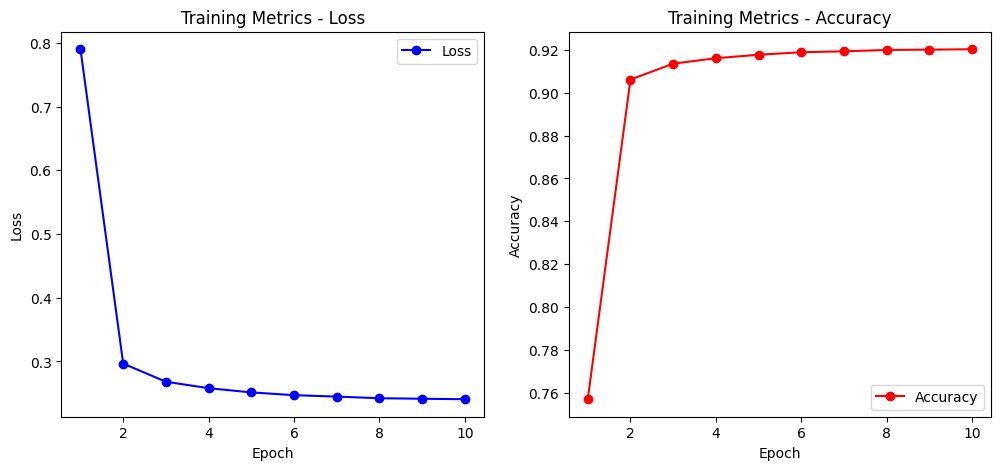

In [155]:
lyrics_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
oxford_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\The_Oxford_3000.txt"
model_save_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\lstm_model_lyrics_generation_oxford3000.pth"


text_i2 = load_combined_data(lyrics_path2, oxford_path2)
dataset2 = LyricsDataset(text_i2)
dataloader2 = DataLoader(dataset2, batch_size=64, shuffle=True)

model2 = LSTMModel(len(dataset2.char_to_int) + 1).to(device)
losses2, accuracies2 = train_model2(model2, dataloader2, epochs=10, lr=0.002)


plot_metrics(losses2, accuracies2)


In [156]:
torch.save(model2.state_dict(), model_save_path2)
print("Model saved successfully.")

Model saved successfully.


In [157]:
user_input = input("Enter the starting words of the song: ")
diversities = [0.04, 0.1, 0.2, 0.5, 1.0, 1.2, 1.5]
final_lyrics2 = generate_and_distribute_lyrics(model2, user_input, dataset2.int_to_char, dataset2.char_to_int, 500, diversities)

for div, lyrics in final_lyrics2.items():
        save_lyrics2(div, lyrics)
        print(f"Diversity {div}:\n{lyrics}\n")

Diversity 0.04:
Harry:
saw you in blue dress is catching you from the stage yeah your smile is on every face now but every

Louis:
time you wake up you're hearing me say goodbye baby you don't have to worry i'll be coming back for you

Zayn:
back for you back for you back for you for you for you for you woah lately i've been going crazy

Niall:
so i'm coming back for you i've never been so into somebody before come somere baby by yourself or are you

Liam:
giving it 'cause heres the tragic truth i can't explain your love no explain your love no maybe it's the way giving it 'cause heres the tragic truth i can't explain your love no explain your love no maybe it's the way she



Diversity 0.1:
Harry:
saw you in blue dress is catching you from the stage yeah your smile is on every fail so close

Louis:
your eyes tonight ooh i pray that you will see the light ooh that we can't live her the light

Zayn:
in her eyes there's no lies no lies there's no question she's not in a disguise with no 

In [ ]:
import matplotlib.pyplot as plt

def load_oxford_words(filepath):
    with open(filepath, 'r') as file:
        words = file.read().split()
    return ' '.join(words)  # Returning as a single string for easy combination

def load_combined_data(lyrics_path, oxford_path):
    lyrics = load__data(lyrics_path)
    oxford_words = load_oxford_words(oxford_path)
    combined_text = lyrics + ' ' + oxford_words
    return combined_text

# Update the train_model to record losses and accuracies
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    losses, accuracies = [], []
    
    model.train()
    for epoch in range(epochs):
        total_loss, total_accuracy = 0, 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            states = model.init_states(inputs.size(0))
            outputs, states = model(inputs, states)
            loss = criterion(outputs.transpose(1, 2), targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total_accuracy += (predicted == targets).float().mean().item()

        losses.append(total_loss / len(dataloader))
        accuracies.append(total_accuracy / len(dataloader))
        print(f'Epoch {epoch+1}, Loss: {losses[-1]:.4f}, Accuracy: {accuracies[-1]:.4f}')
    
    return losses, accuracies

# Function to plot losses and accuracies
def plot_metrics(losses, accuracies, title="Training Metrics"):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo-', label='Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'ro-', label='Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage:
lyrics_path = "path_to_lyrics.parquet"
oxford_path = "/path_to_Oxford_3000.txt"
text = load_combined_data(lyrics_path, oxford_path)
dataset = LyricsDataset(text)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
model = LSTMModel(len(dataset.char_to_int) + 1).to(device)
losses, accuracies = train_model(model, dataloader, epochs=10, lr=0.001)
plot_metrics(losses, accuracies)
